In [222]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

import pandas as pd
import numpy as np
import cv2 as cv
import scanpy as sc
import os
import gc
import zarr
import tifffile
import json

from skimage.transform import rescale, resize, rotate
from skimage.io import imread
from skimage.color import rgb2gray
from scipy import ndimage as ndi

from skimage.draw import disk
import torch

device = torch.device('cpu')
xenium_path = '/kaggle/input/xenium-breastcancerdataset'
visium_path = '/kaggle/input/breastcancerdatset/BreastCancerDataset'

In [188]:
# Reading in Xenium image
img = cv.imread("/kaggle/input/xenium-breastcancerdataset/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image_registerd.png")
xenium_downsampled = cv.resize(img, (2662, 1937), interpolation=cv.INTER_AREA)
xenium_rescale = cv.cvtColor(xenium_downsampled, cv.COLOR_RGB2GRAY)

In [237]:
# Reading in Visium image
img = cv.imread('/kaggle/input/breastcancerdatset/BreastCancerDataset/spatial/tissue_hires_image.png')

visium_downsampled = cv.resize(img, (2157,1950), interpolation=cv.INTER_AREA)
visium_rescale = cv.cvtColor(visium_downsampled, cv.COLOR_RGB2GRAY)

del img, visium_downsampled, xenium_downsampled
gc.collect()

In [186]:
# Xenium Coordinates
xenium_profile = pd.read_csv('/kaggle/input/xenium-breastcancerdataset/cells.csv', index_col=[0])
xenium_coords = xenium_profile.loc[:, ['x_centroid', 'y_centroid']].values
xenium_profile.head()

x_centroid  y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                    
1        847.259912  326.191365                 28                     1   
2        826.341995  328.031830                 94                     0   
3        848.766919  331.743187                  9                     0   
4        824.228409  334.252643                 11                     0   
5        841.357538  332.242505                 48                     0   

         control_codeword_counts  total_counts   cell_area  nucleus_area  
cell_id                                                                   
1                              0            29   58.387031     26.642187  
2                              0            94  197.016719     42.130781  
3                              0             9   16.256250     12.688906  
4                              0            11   42.311406     10.069844  
5                              0            48  107.652500     37.479687

In [187]:
# Rescale Xenium coordinates to the size of downscaled H&E
ratio_x = xenium_rescale.shape[1] / xenium_coords[:, 0].max()
ratio_y = xenium_rescale.shape[0] / xenium_coords[:, 1].max()
xenium_coords_aligned = xenium_coords * np.array([ratio_x, ratio_y])  # Col. order: [X, Y]

display(xenium_coords_aligned[:10])
del ratio_x, ratio_y, xenium_coords

array([[299.79793221, 115.37654691],
       [292.39625047, 116.02753432],
       [300.33117771, 117.34027161],
       [291.64837035, 118.22788662],
       [297.70941182, 117.51688443],
       [300.06767572, 119.04895413],
       [295.56053233, 119.60135435],
       [293.23990109, 120.86644499],
       [299.91936635, 121.85651912],
       [296.79196449, 122.13782979]])

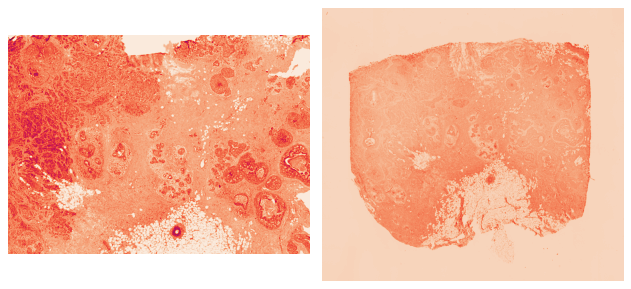

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12), dpi=80)
ax1.imshow(xenium_rescale)
ax1.axis('off')

ax2.imshow(visium_rescale)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [190]:
sift = cv.SIFT_create()

img_src = np.round(visium_rescale*255).astype(np.uint8)
img_dst = np.round(xenium_rescale*255).astype(np.uint8)
pts_src, des_src = sift.detectAndCompute(img_src, None)
pts_dst, des_dst = sift.detectAndCompute(img_dst, None)

matcher = cv.BFMatcher()
matches = matcher.knnMatch(des_src, des_dst, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

pts1 = np.float32([pts_src[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([pts_dst[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, _ = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)
visium_aligned = cv.warpPerspective(img_src, H, (img_dst.shape[1], img_dst.shape[0]))

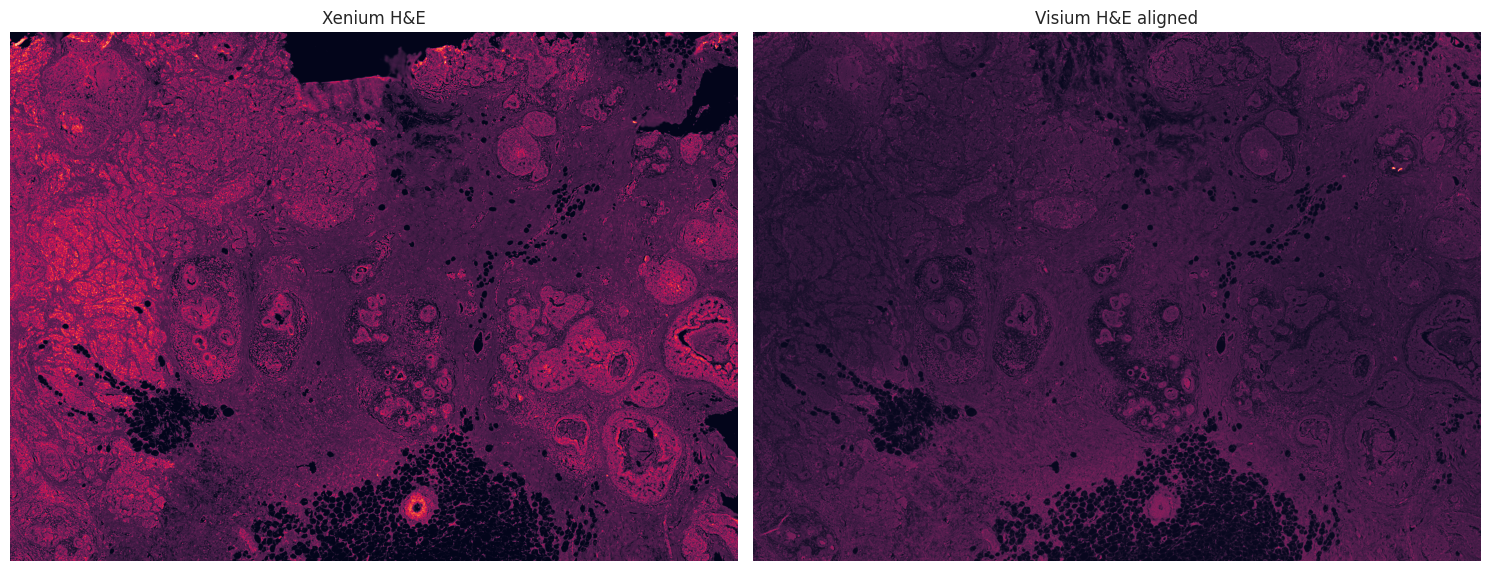

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(img_dst)
ax1.axis('off')
ax1.set_title('Xenium H&E')

ax2.imshow(visium_aligned)
ax2.axis('off')
ax2.set_title('Visium H&E aligned')

plt.tight_layout()
plt.show()

In [192]:
adata_visium = sc.read_visium(visium_path)
adata_visium.obsm['spatial'] = adata_visium.obsm['spatial'].astype(np.uint32)

# Getting Visium Spot Coordinates
visium_profile = pd.read_csv("/kaggle/input/breastcancerdatset/tissue_positions.csv", index_col=[0])
visium_coords = visium_profile.loc[:, ['pxl_col_in_fullres', 'pxl_row_in_fullres']]  # Ordering [X, Y]

# Taking only the first 500 spots
temp = visium_coords[:500]
obs_names_500 = adata_visium.obs_names
for name in obs_names_500:
    if not name in temp.index: 
        obs_names_500 = obs_names_500.drop(name)

visium_coords = temp.loc[obs_names_500]
display(visium_coords.head(10))

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


pxl_col_in_fullres  pxl_row_in_fullres
AACACCTACTATCGAA-1                4131                4636
AACCAAGCGTGGCCTC-1                5775                4623
AACCATAGAATTCGAA-1                3953                5273
AACCGCGGTAACTACA-1                7330                5088
AACGACATTAAGATGG-1               11718                5690
AACGCACTGGTGCTCG-1               12814                5681
AACGCTTCGAGTAACT-1                7693                4767
AACTAGCCTAATAGCA-1               10440                5700
AACTATTGGCGGATTC-1               13720                4721
AACTGCAATACGGATT-1               10255                5383

In [606]:
visium_coords_rescaled = visium_coords.values * 0.1

# Apply coordinate transform coording to homography:
visium_coords_aligned = cv.perspectiveTransform(
    np.expand_dims(visium_coords_rescaled, axis=0).astype(np.float32),
    H
).squeeze()

In [607]:
with open(os.path.join(visium_path, 'spatial/scalefactors_json.json'), 'r') as ifile:
    visium_json = json.load(ifile)
    visium_img_prof = {'tissue_hires_scalef': visium_json['tissue_hires_scalef'],
                       'spot_diameter_fullres': visium_json['spot_diameter_fullres']
                      }
    del visium_json

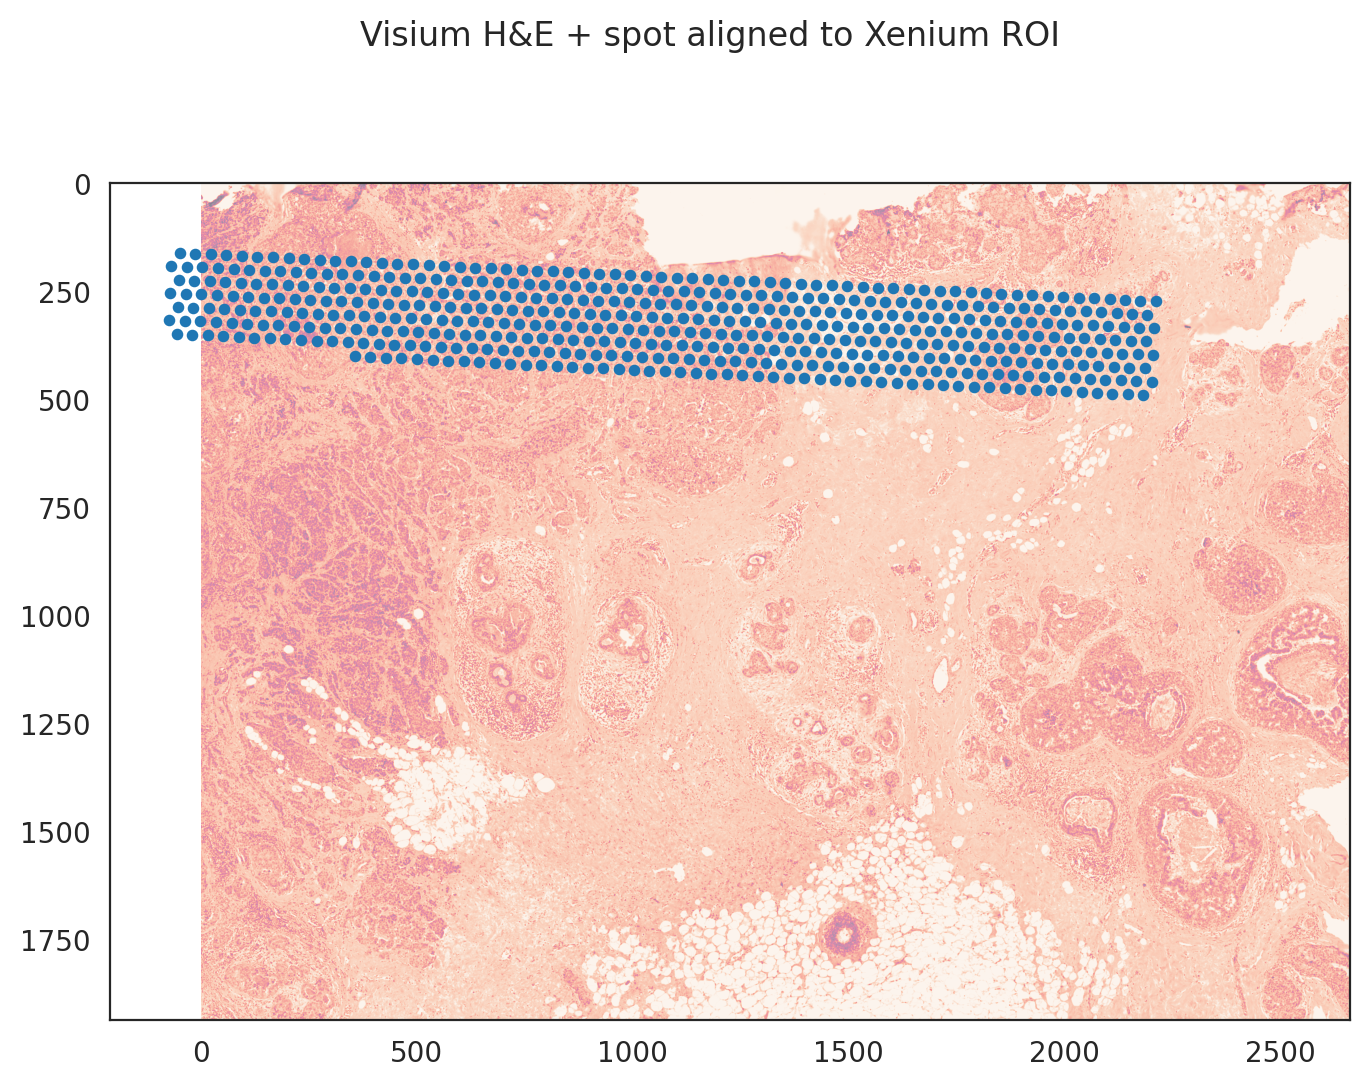

In [349]:
# Spatial plot of aligned Visium H&E and spots
plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(xenium_rescale, alpha=0.5)
plt.scatter(*visium_coords_aligned[:500].T, s=10)
plt.suptitle('Visium H&E + spot aligned to Xenium ROI')
plt.show()

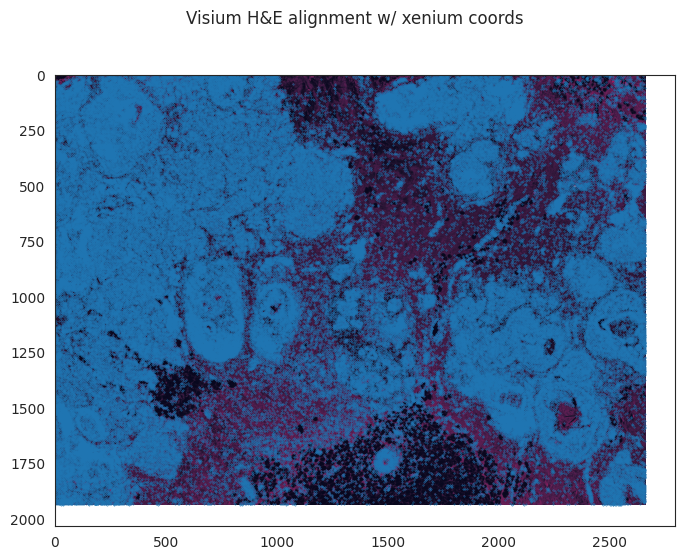

In [254]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(visium_aligned)
diam = int(visium_img_prof['spot_diameter_fullres'] * 0.1)

plt.scatter(*xenium_coords_aligned.T, s=0.1)
plt.suptitle('Visium H&E alignment w/ xenium coords')
plt.show()

del diam
gc.collect()

In [327]:
# Reading in xenium cell type annotations
annot_dict = {
    'Cluster 0':              'Stromal/Endothelial',
    'Cluster 1':              'Stromal/Endothelial/Immune',
    'Cluster 2':              'Adipocytes',
    'Cluster 3':              'Invasive',
    'Cluster 4':              'Stromal/Endothelial',
    'Cluster 5':              'Mixed/Invasive',
    'Cluster 6':              'DCIS #1',
    'Cluster 7':              'Stromal',
    'Cluster 8':              'Immune',
    'Cluster 9':              'Mixed',
    'Cluster 10':             'Stromal',
    'Cluster 11':             'Mixed',
    'Cluster 12':             'DCIS #2',
    'Cluster 13':             'Invasive',
    'Cluster 14':             'Myoepithelial/Stromal/Immune',
    'Cluster 15':             'DCIS #2',
    'Cluster 16':             'Invasive'
}

xenium_annot_df = pd.read_csv("/kaggle/input/xenium-breastcancerdataset/Xenium_annot_full.csv", index_col=[0])#, usecols=[1, 2])
xenium_annot = xenium_annot_df['Cluster'].apply(lambda x: annot_dict[x] if x in annot_dict else 'None')
display(pd.Series(xenium_annot).value_counts())
del xenium_annot_df

Cluster
Invasive                        27951
Stromal/Endothelial/Immune      24022
Adipocytes                      20259
Stromal/Endothelial             16089
Stromal                         14478
Mixed/Invasive                  13948
Mixed                           12042
DCIS #2                         10224
DCIS #1                          9726
Immune                           7255
None                             6996
Myoepithelial/Stromal/Immune     4790
Name: count, dtype: int64

In [203]:
# Load Xenium mask
store = zarr.open(os.path.join(xenium_path, 'cells.zarr'), mode='r')
masks = store['masks'][0][:]
del store

In [316]:
visium_coords_upscale = np.round(visium_coords_aligned * 10).astype(int)
# Define area around each visium spot
def get_masked_disk(coord, r, size):
    # Note that coord has [X, Y] order
    x, y = coord
    rr, cc = disk(tuple([y, x]), r, shape=size)
    return rr, cc

In [608]:
# Get the upscaled visium coords (assigning to Xenium masks in the original resolution)
# visium_coords_upscale = np.round(visium_coords_aligned * 10).astype(np.int32)

# Note: mask dimension is [I, J] ([Y, X]), coord axis order is [X, Y]

spot_cell_map = {} # map of spots w/ cells inside each spot
cell_spot_map = {} # map of cells w/ each cell's spot location
cell_area = {}
size = masks.shape

for visium_idx, coord in enumerate(visium_coords_upscale):
    rr, cc = get_masked_disk(coord, r=np.ceil(visium_img_prof['spot_diameter_fullres']/2), size=size)
    labels, counts = np.unique(masks[rr, cc], return_counts=True)
    if len(labels) > 0: 
        if labels[0] == 0:
            labels, counts = labels[1:], counts[1:]
        
    spot_cell_map[visium_idx] = labels
        
    for label, count in zip(labels, counts):
        cell_spot_map.setdefault(label, []).append(visium_idx)
        cell_area.setdefault(label, []).append(count)

del visium_idx, coord, label, count, labels, counts

In [609]:
spot_cell_type = {}
for spot in spot_cell_map:
    for cell in spot_cell_map[spot]:
        if not spot in spot_cell_type: spot_cell_type[spot] = [xenium_annot[cell]]
        else: spot_cell_type[spot].append(xenium_annot[cell])

In [611]:
types = ['Invasive','Stromal/Endothelial/Immune','Adipocytes','Stromal/Endothelial',
        'Stromal','Mixed/Invasive','Mixed','DCIS #1','DCIS #2','Immune','None',
         'Myoepithelial/Stromal/Immune']

In [612]:
map1 = {val:i for i,val in enumerate(types)}

arr = np.zeros([500,12])
for key, values in spot_cell_type.items():
    total_count = len(values)
    for val in values:
        arr[key,map1[val]] += 1
    arr[key,:] /= total_count

In [613]:
# Calculate percentage for each value in each key
xenium_cell_percent = {}
for key, values in spot_cell_type.items():
    counts = {}
    total_count = len(values)
    for value in values:
        counts[value] = counts.get(value, 0) + 1
    xenium_cell_percent[key] = {value: (count / total_count) * 100 for value, count in counts.items()}

In [614]:
sf_cell_percent = torch.load("/kaggle/input/breastcancerdatset/Starfysh_Outputs/inference_outputs/qc_m.pt").numpy()
sf_df = pd.DataFrame(sf_cell_percent)

reg_sf = pd.read_csv("/kaggle/input/breastcancerdatset/inference.csv")
reg_sf = reg_sf.drop(columns = 'Unnamed: 0')

x_df = pd.DataFrame(arr)
x_df.columns = ['invasive','stromal/endothelial/immune','adipocytes','stromal/endothelial',
                 'stromal','mixed/invasive','mixed','DCIS #1','DCIS #2','immune','None',
                 'Myoepithelial/Stromal/Immune']
x_df = x_df.drop(columns=['DCIS #1','DCIS #2','None','Myoepithelial/Stromal/Immune'])

In [587]:
error_sf = np.square(sf_df.values / 100 - x_df.values / 100) 
error_sf.sum() / 500

0.4604158

In [588]:
error_reg_sf = np.square(reg_sf.values / 100 - x_df.values / 100) 
error_reg_sf.sum() / 500

0.4672214

<Axes: >

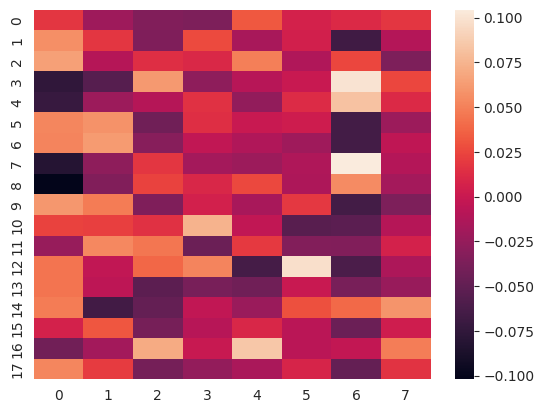

In [622]:
sf_df = pd.DataFrame(sf_cell_percent)
corr_sf = generate_correlation_map(sf_df.values.T, x_df.values.T)
sns.heatmap(corr_sf)

<Axes: >

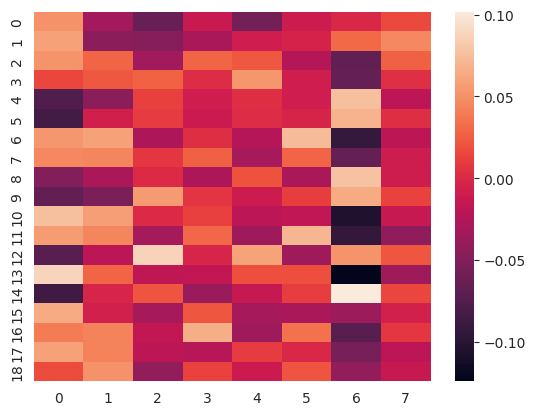

In [605]:
corr_reg_sf = generate_correlation_map(reg_sf.values.T, x_df.values.T)
sns.heatmap(corr_reg_sf, label="title")